# Financial Econometrics 1: Homework 1

Jan Kubal & Matyáš Mattanelli

## Problem 1

<a id='data_preparation'></a>
### Data preparation

First, we start with downloading and preparing data. We loaded the ticker sheet, set a seed at random, and draw a random sector based on this seed. This procedure yielded us with the Health Care Sector. We thus took a subsample from all tickers, restricting the sector accordingly. 


In [2]:
##loading packages
#install.packages("quantmod")
library(quantmod) #for downloading data

#install.packages("EnvStats") 
library(EnvStats) #used for computing excess kurtosis

#install.packages("StableEstim")
library(StableEstim) #for stable distribution estimation

##Data Preparation
#loading data
tickers <- read.csv("symbols.csv", sep = ";")

#summary and renaming
names(tickers) <- c("Symbol", "Name", "Sector")
summary(tickers)

#examining the number of tickers for each sector
for (i in unique(tickers$Sector)) {
  print(i)
  print(nrow(subset(tickers, tickers$Sector == i)))
}

#choosing sector at random
set.seed(1535) ###<---------------------------Change the seed here for different sector
sector <- sample(unique(tickers$Sector), 1)
print("Sector selected:")
print(sector)
tickers_sub <- subset(tickers, tickers$Sector == sector)
summary(tickers_sub)

    Symbol              Name              Sector         
 Length:500         Length:500         Length:500        
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  

[1] "Industrials"
[1] 61
[1] "Financials"
[1] 82
[1] "Health Care"
[1] 52
[1] "Consumer Discretionary"
[1] 83
[1] "Information Technology"
[1] 69
[1] "Utilities"
[1] 33
[1] "Materials"
[1] 29
[1] "Energy"
[1] 43
[1] "Consumer Staples"
[1] 40
[1] "Telecommunications Services"
[1] 8
[1] "Sector selected:"
[1] "Health Care"


    Symbol              Name              Sector         
 Length:52          Length:52          Length:52         
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  

Next, we set the starting and ending date of our sample. Note that the end date was set one day further, to include 2021-31-12 in getSymbols() result.

In [3]:
#setting the start and end dates
date_start <- as.Date("2015-01-01")
date_end <- as.Date("2022-01-01")

For the purpose of this homework, we have defined a function, that accepts the list of tickers, the starting and ending dates, and a position of the closing prices column as parameters. The function performs several steps:
1. Downloads data for each ticker from YAHOO, using the getSymbols() function from the quantmod package.
2. Identifies the time-series with the largest number of observations i.e. the threshold.
3. Keeps only data on tickers, for which the sample size is not smaller than 80% of the threshold.
4. From those, keep only the column with closing prices (in our case it is the fourth column for all tickers, in case of some different format, the function would have to be changed accordingly).
5. Returns the list of two elements, first being the list containing the closing prices and timestamps for the remaining tickers, and the second being the list of strings, representing the tickers used.

In [4]:
#Data download as a function
data_preparation <- function(tickers,
                          date_start = as.Date("2015-01-01"),
                          date_end = as.Date("2022-01-01"),
                          closing_col = 4) { ###<--- Here the Closing price is assumed to have the 4th position
  
  prices <- vector("list", length(tickers$Symbol))
  data_available <- vector("logical", length(tickers$Symbol))
  data_usable <- vector("logical", length(tickers$Symbol))
  
  for (i in 1:length(tickers$Symbol)) {
    tryCatch({
      prices[[i]] <- getSymbols(tickers$Symbol[i], src = 'yahoo', auto.assign = FALSE, , from = date_start, to = date_end)
      #message(paste("Dwonloaded data for ",  tickers$Symbol[i]), ". Progress: ", i, " out of ", length(tickers$Symbol), sep = "") #indicators omitted for brevity
      data_available[i] <- TRUE #logical vector only for the purpose of message printing
      }, error = function(e) {
      #message(paste("Data unavailiable for ticker ", i, ": ", tickers$Symbol[i], sep = ""))
      #message(paste("Original error message:", e))
    })
  }
  
  sample_size <- max(sapply(prices, function(x) {sum(!is.na(x[,closing_col]))})) 
  
  #creating logical vector indicating which data are complete enough to be used further
  data_usable <- sapply(prices, function(x) {sum(!is.na(x[,closing_col])) >= sample_size*0.8})
  tickers_used <- subset(tickers, data_usable)
  
  #saving only the closing prices of the usable data
  prices_used <- vector("list", sum(data_usable))
  iter_helper <- 1
  for (i in 1:length(data_usable)) {
    if (data_usable[i]) {
      prices_used[[iter_helper]] <- prices[[i]][, closing_col]
      iter_helper <- iter_helper + 1
    }
  }
  
  return(list(closing_prices = prices_used, tickers = tickers_used))
}

The above described function put to use:

In [5]:
#downloading data
data_downloaded <- data_preparation(tickers_sub, date_start = date_start, date_end = date_end)
#defining the elements of a list as standalone objects
prices_clr_closing <- data_downloaded$closing_prices
tickers_clr <- data_downloaded$tickers

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.


Warning message:
"AET contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."
Warning message:
"ALXN download failed; trying again."
Warning message:
"AGN download failed; trying again."
Warning message:
"BCR download failed; trying again."
Warning message:
"CFN download failed; trying again."
Warning message:
"CELG download failed; trying again."
Warning message:
"CVH contains missing values. Some functions will not work if o

Bellow, we check that we have only the desired tickers and the column of the closing price.

In [6]:
for (i in 1:length(prices_clr_closing)) {
  print(summary(prices_clr_closing[[i]]))
}

     Index              ABT.Close     
 Min.   :2015-01-02   Min.   : 36.34  
 1st Qu.:2016-10-01   1st Qu.: 45.34  
 Median :2018-07-03   Median : 63.13  
 Mean   :2018-07-03   Mean   : 71.14  
 3rd Qu.:2020-04-02   3rd Qu.: 89.08  
 Max.   :2021-12-31   Max.   :141.46  
     Index               A.Close      
 Min.   :2015-01-02   Min.   : 33.37  
 1st Qu.:2016-10-01   1st Qu.: 46.19  
 Median :2018-07-03   Median : 67.39  
 Mean   :2018-07-03   Mean   : 74.57  
 3rd Qu.:2020-04-02   3rd Qu.: 84.80  
 Max.   :2021-12-31   Max.   :179.28  
     Index              ABC.Close     
 Min.   :2015-01-02   Min.   : 69.03  
 1st Qu.:2016-10-01   1st Qu.: 84.72  
 Median :2018-07-03   Median : 90.14  
 Mean   :2018-07-03   Mean   : 93.98  
 3rd Qu.:2020-04-02   3rd Qu.:102.15  
 Max.   :2021-12-31   Max.   :133.77  
     Index              AMGN.Close   
 Min.   :2015-01-02   Min.   :132.2  
 1st Qu.:2016-10-01   1st Qu.:162.9  
 Median :2018-07-03   Median :183.9  
 Mean   :2018-07-03   Mean   

### Task 1)
Next, we create lists rets and lrets, containing returns and log-returns for the closing prices. For this, lapply() function was used in combination with diff(). We summarize a random element of lrets to check the proper structure.

In [7]:
#creating returns and log-returns: rets and lrets
rets <- lapply(prices_clr_closing, function(y) {
  y <- na.omit(diff(y))
  colnames(y) <- "return"
  return(y)
})
names(rets) <- tickers_clr$Symbol

lrets <- lapply(prices_clr_closing, function(y) {
  y <- na.omit(diff(log(y)))
  colnames(y) <- "log_return"
  return(y)
})
names(lrets) <- tickers_clr$Symbol

summary(lrets[[5]])

     Index              log_return        
 Min.   :2015-01-05   Min.   :-0.1236497  
 1st Qu.:2016-10-03   1st Qu.:-0.0056765  
 Median :2018-07-04   Median : 0.0009818  
 Mean   :2018-07-04   Mean   : 0.0004359  
 3rd Qu.:2020-04-02   3rd Qu.: 0.0077477  
 Max.   :2021-12-31   Max.   : 0.1177054  

### Task 2)
In this task, we have created a matrix displaying several statistics (mean, variance, skewness, excess kurtosis, minimum, and maximum) for each series of Log-Returns. The tickers saved at the end of the data preparation were used to name the rows of the matrix.

In [8]:
#creating matrix
statistics_mat <- matrix(data = NA, nrow = length(tickers_clr$Symbol), ncol = 6)
#specifying names of rows and columns
row.names(statistics_mat) <- tickers_clr$Symbol
colnames(statistics_mat) <- c("mean", "variance", "skewness", "excess_kurtosis", "minimum", "maximum")

#filling the matrix
for (i in 1:nrow(statistics_mat)) {
  statistics_mat[i, 1] <- mean(as.numeric(lrets[[i]]$log_return))
  statistics_mat[i, 2] <- var(as.numeric(lrets[[i]]$log_return))
  statistics_mat[i, 3] <- skewness(as.numeric(lrets[[i]]$log_return))
  statistics_mat[i, 4] <- kurtosis(as.numeric(lrets[[i]]$log_return, excess = TRUE))
  statistics_mat[i, 5] <- min(as.numeric(lrets[[i]]$log_return))
  statistics_mat[i, 6] <- max(as.numeric(lrets[[i]]$log_return))
}

#statistics_mat
View(statistics_mat)

,mean,variance,skewness,excess_kurtosis,minimum,maximum
ABT,6.483975e-04,2.360315e-04,-0.519731669,7.906141,-0.10298188,0.10378337
A,7.776399e-04,2.524292e-04,-0.636406605,6.441942,-0.11666543,0.09384909
ABC,2.182826e-04,3.279465e-04,-0.240206989,8.003130,-0.13962360,0.11167674
AMGN,1.938031e-04,2.592008e-04,0.047060919,5.409916,-0.10075572,0.10343813
BAX,4.359233e-04,2.101031e-04,-0.651965804,10.922692,-0.12364967,0.11770543
BDX,3.329861e-04,2.002444e-04,-0.736354227,9.688995,-0.12553615,0.10772397
BIIB,-2.012114e-04,7.706841e-04,0.286223124,60.202961,-0.34574177,0.36446208
BSX,6.624873e-04,3.196382e-04,-0.342317944,8.474473,-0.15999315,0.11688416
BMY,2.645818e-05,2.631640e-04,-1.793671195,16.156509,-0.17417640,0.06618027
CAH,-2.536855e-04,3.808421e-04,-1.745015961,20.109307,-0.24109180,0.11634036


### Task 3)
Bellow, we plot the Log-Returns in one figure. As there are 36 distinct time-series in our subset (for the case of the Health Care sector), the figure is not very informative in terms of return on individual assets (the first plot contains Log-Returns on the first asset, but to display all the Log-Returns separately would be meaningless). However, overall we can see that the first half of 2020 was the most volatile period from the examined time span (the Log-Returns are changing rapidly and crossing zero often). This is very likely due to the breakout of the Covid-19 pandemic.

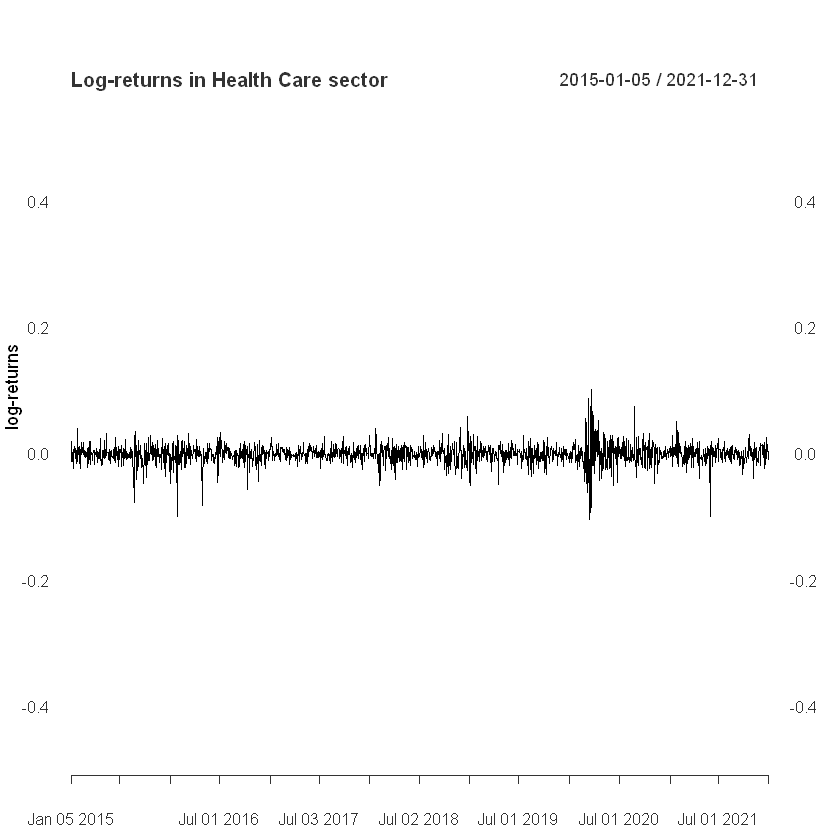

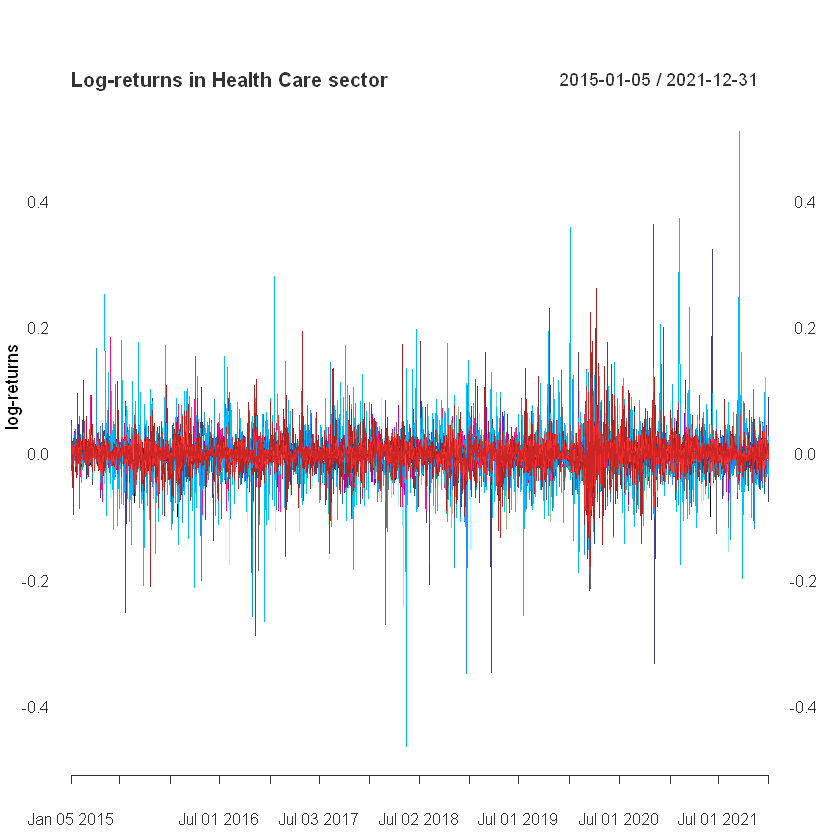

In [9]:
#creating the plot
plot.xts(lrets[[1]]$log_return, col = "black", grid.col = "white", lwd = 1, ylim = c(min(statistics_mat[,5]), max(statistics_mat[,6])), ylab = "log-returns", main = paste("Log-returns in ", sector, " sector", sep = ""))
#adding the remaining lines
lines_list <- vector("list", length(lrets) - 1)

for (i in 2:length(lrets)) {
  lines_list <- (lines(lrets[[i]]$log_return, col = colors()[i + 100]))
}

lines_list

### Task 4)
We have already filtered the data such that they have at most 20% observation missing, compared to the series with the highest number of observations, in the [Data preparation](#data-preparation) section. Bellow, we create a sequence of dates and check, whether for each date we have information on Log-Returns for all the tickers. In case we do, we compute the mean for that specific date. In the case of one or more NAs, the specific date is disregarded. The summary of the mean Log-Returns is then printed to check the result.

In [10]:
#creating empty dataframe to enter the log-ret means
lrets_means <- data.frame(date = seq.Date(from = date_start, to = date_end - 1, by = 1), lret_mean = rep(NA, as.numeric(date_end-date_start)))

#the following for loop goes through the sequence of dates of our interest, checks that we have observation for log-returns of each of the tickers and saves the mean of those log-returns
for (i in 1:nrow(lrets_means)) {
  iter_date <- lrets_means$date[i]
  date_lrets <- rep(NA, length(lrets))
  for (j in 1:length(lrets)) {
    
    if (nrow(lrets[[j]][iter_date, ]) == 1) {
      date_lrets[j] <-  as.numeric(lrets[[j]][iter_date, ])
    }
    
  }
  #print(paste("Iteration", i, "out of", nrow(lrets_means),  "Date:", iter_date)) #indicator omitted for brevity
  
  
  
  if (sum(is.na(date_lrets)) == 0) {
    lrets_means$lret_mean[i] <- mean(date_lrets)
  }
}


summary(lrets_means)

      date              lret_mean      
 Min.   :2015-01-01   Min.   :-0.1045  
 1st Qu.:2016-10-01   1st Qu.:-0.0045  
 Median :2018-07-02   Median : 0.0006  
 Mean   :2018-07-02   Mean   : 0.0003  
 3rd Qu.:2020-04-01   3rd Qu.: 0.0062  
 Max.   :2021-12-31   Max.   : 0.0738  
                      NA's   :890      

### Task 5)
Using the Estim() function from the StableEstim package, we estimate the parameters of the stable distribution.

In [11]:
#Omitting the NAs in the mean log-rets
lrets_means_sub <- subset(lrets_means, !is.na(lrets_means$lret_mean))
#Estimating parameters of stable distribution based on mean log returns per day for all the tickers
stable_dist_estim <- Estim(EstimMethod = "Kout", data = lrets_means_sub$lret_mean)
stable_dist_estim

*** Class Estim, method Show *** 
** Method ** 
[1] "Koutrouvelis_spacing=Kout"
** Parameters Estimation ** 
       alpha         beta        gamma        delta 
 1.644168947 -0.513861514  0.005697560  0.001393148 
** Covariance Matrix Estimation ** 
     [,1] [,2] [,3] [,4]
[1,]   NA   NA   NA   NA
[2,]   NA   NA   NA   NA
[3,]   NA   NA   NA   NA
[4,]   NA   NA   NA   NA
** Confidence interval Estimation ** 
[1] "Confidence level= 0"
[1] "data length= 1667"
     [,1] [,2]
[1,]   NA   NA
[2,]   NA   NA
[3,]   NA   NA
[4,]   NA   NA
attr(,"level")
[1] 0
** Estimation time ** 
[1] " :duration= 0  h, 0  min, 3  sec. "
** Estimation status ** 
success
 ******* End Show (Estim) ******* 

### Task 6)
Lastly, we plot the histogram of the Log-Returns and the two densities - of normal distribution with mean and variance taken from the Log-Returns, and of the stable distribution with parameters estimated in the previous task.

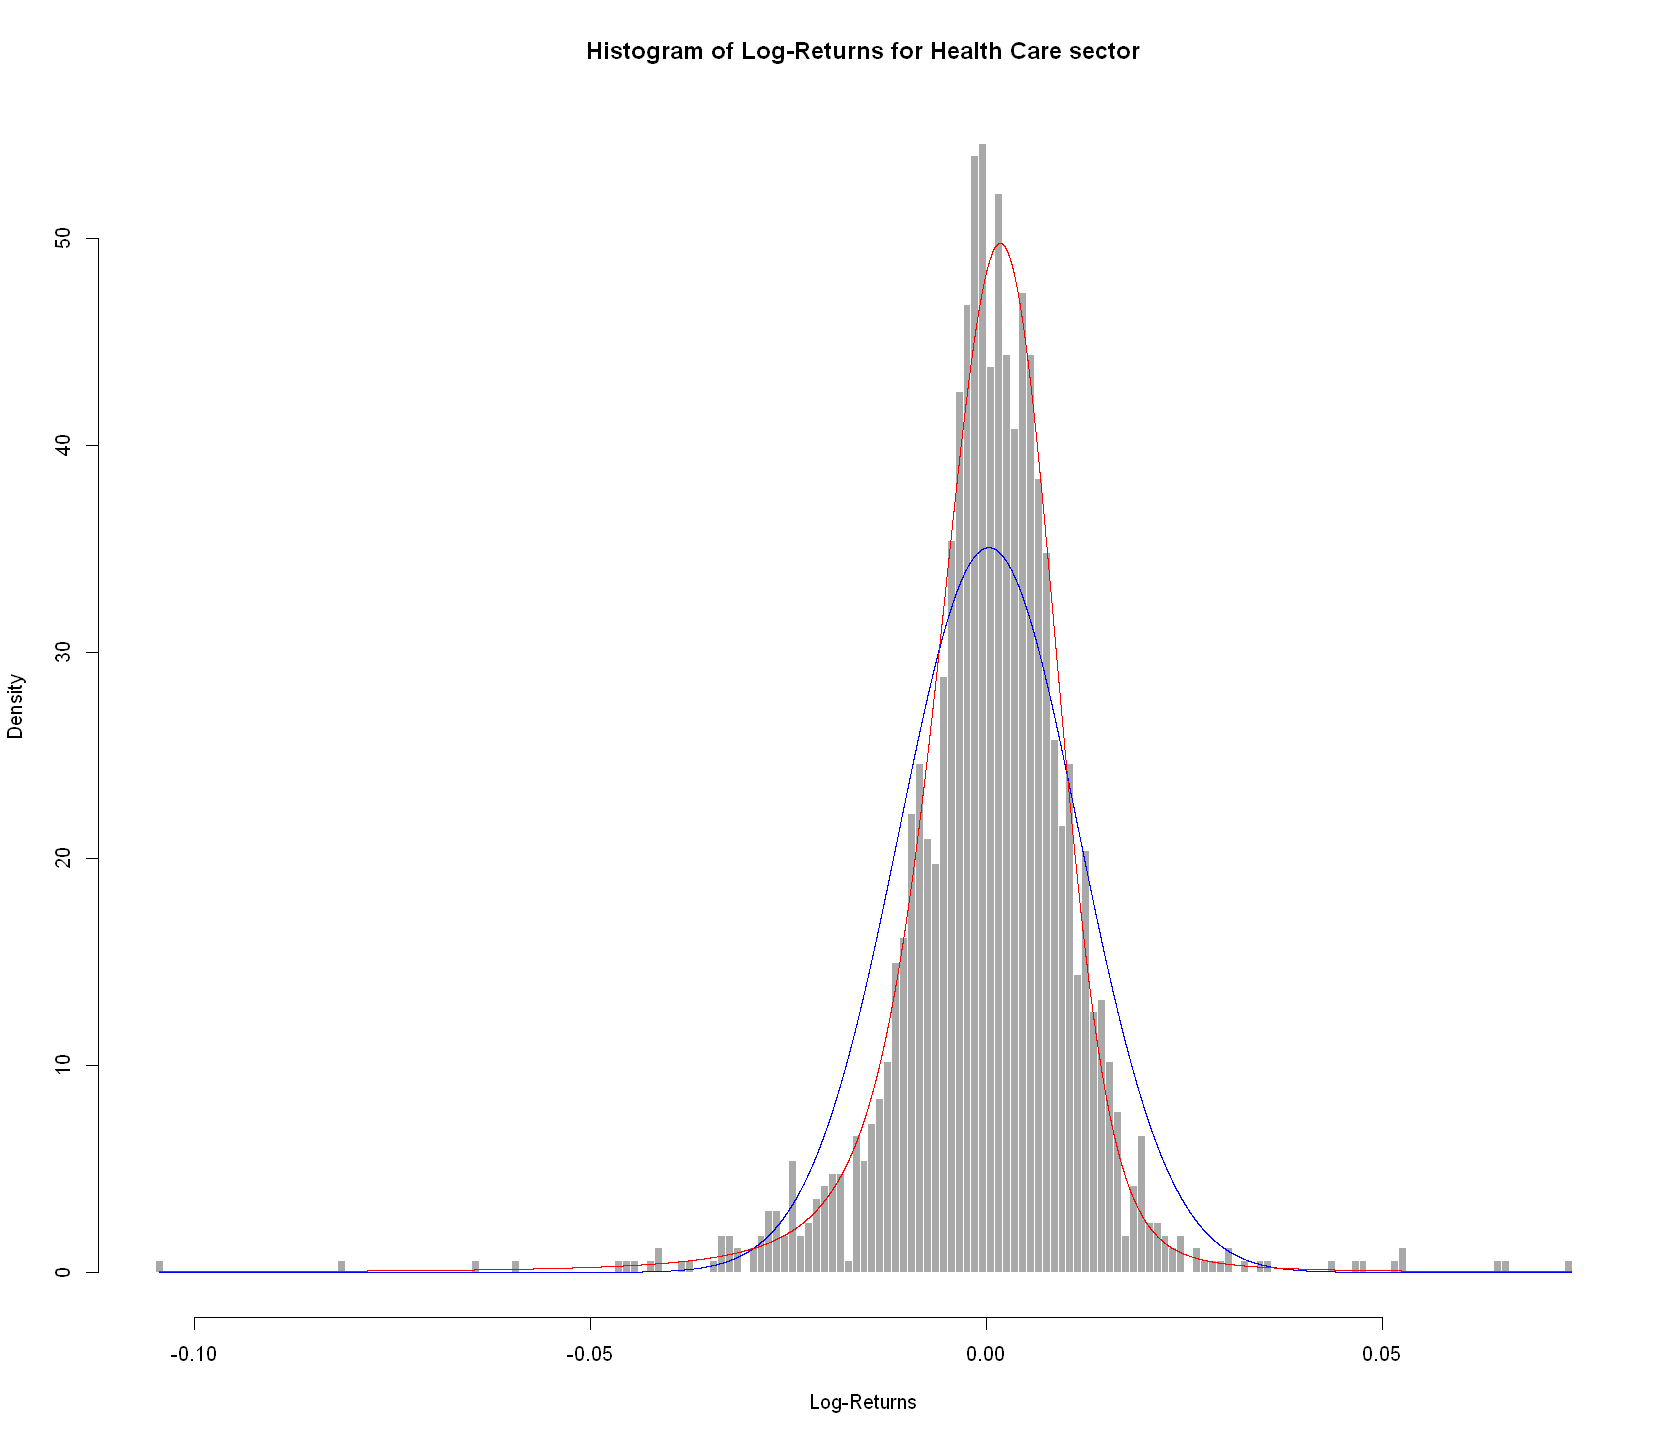

In [12]:
#plotting histogram of the mean log-returns
options(repr.plot.width = 14, repr.plot.height = 12)
hist(lrets_means_sub$lret_mean,
     nclass = 200,
     freq = FALSE,
     border = "white",
     col = "darkgrey",
     xlab = "Log-Returns",
     main = paste("Histogram of Log-Returns for ", sector, " sector", sep = ""))
     
#defining features of the normal distribution
density_seq <- seq(from = min(lrets_means_sub$lret_mean),
                to = max(lrets_means_sub$lret_mean),
                by = 0.00001)
norm_m <- mean(lrets_means_sub$lret_mean)
norm_std <- sd(lrets_means_sub$lret_mean)

#adding a line representing the normal distribution
lines(x = density_seq,
      y = dnorm(density_seq,
                mean = norm_m,
                sd = norm_std),
      col = "blue")

#adding the line representing stable distribution, using the parameters estimated based on the mean log-returns
lines(x = density_seq, 
      y = dstable(density_seq, 
                  alpha = stable_dist_estim@par[1],
                  beta = stable_dist_estim@par[2],
                  gamma = stable_dist_estim@par[3],
                  delta = stable_dist_estim@par[4]),
      col = "red")

The result is as expected. The histogram follows the density curve of stable distribution (not perfectly, but reasonably close), while it differs significantly from the normal distribution. The data have apparent fat tails, especially in the case of negative log-returns, meaning that the outliers are more likely to occur than in the case of normal distribution. Also, more values seem to be concentrated around the mean (zero), which is a sign of excess kurtosis.

#### Concluding remark
The code is written in such a way that it works for any sector, the only change required is to enter a different seed at the Data Preparation section.

---

## Problem 2

### 1.

Firstly, we will compute the mean of the $p_t$ process. We know that:
$$
p_t=p_{t-1}+\epsilon_t-\epsilon_{t-1} \\
p_{t-1}=p_{t-2}+\epsilon_{t-1}-\epsilon_{t-2} \\
p_{t-2}=p_{t-3}+\epsilon_{t-2}-\epsilon_{t-3} \\
... \\
p_2=p_1+\epsilon_2-\epsilon_1 \\
p_1=p_0+\epsilon_1-\epsilon_0
$$

Therefore:
$$
p_t=p_0-\epsilon_0+\epsilon_1-\epsilon_1+...+\epsilon_{t-1}-\epsilon_{t-1}+\epsilon_t=p_0-\epsilon_0+\epsilon_t
$$

From that and considering that $E(\epsilon_0)=E(\epsilon_t)=0$ and $E(p_0)=p_0$ since $p_0$ is a constant, the mean is:
$$
E(p_t)=E(p_0-\epsilon_0+\epsilon_t)=E(p_0)-E(\epsilon_0)+E(\epsilon_t)=p_0
$$

As a result, the mean is equal to the initial value of $p_t$ denoted by $p_0$. With that knowledge we can find the variance of the $p_t$ process in a similar way:

$$
Var(p_t)=E(p_t^2)-[E(p_t)]^2=E[(p_0-\epsilon_0+\epsilon_t)^2]-p_0^2=E(p_0^2-p_0\epsilon_0+p_0\epsilon_t-p_0\epsilon_0+\epsilon_0^2-\epsilon_0\epsilon_t+p_0\epsilon_t-\epsilon_0\epsilon_t+\epsilon_t^2)-p_0^2=\\=E(p_0^2-2p_0\epsilon_0+2p_0\epsilon_t+\epsilon_0^2-2\epsilon_0\epsilon_t+\epsilon_t^2)-p_0^2=E(p_0^2)-E(2p_0\epsilon_0)+E(2p_0\epsilon_t)+E(\epsilon_0^2)-E(2\epsilon_0\epsilon_t)+E(\epsilon_t^2)-p_0^2=\\=p_0^2-2p_0E(\epsilon_0)+2p_0E(\epsilon_t)+\sigma_{\epsilon}^2-2E(\epsilon_0)E(\epsilon_t)+\sigma_{\epsilon}^2-p_0^2=2\sigma_\epsilon^2=2*4=8
$$

We used the facts that $Var(X)=E[(X-E(X))^2]=E(X^2)-[E(X)]^2$, $E(XY)=E(X)E(Y)$ when $X$ and $Y$ are independent, $E(\epsilon_t)=0$, and $E(\epsilon_t^2)=Var(\epsilon_t)+[E(\epsilon_t)]^2=\sigma_\epsilon^2+0^2=\sigma_\epsilon^2=4$.

Analogously, we can compute the mean and the variance for the $r_t$ process. We know that:
$$
\epsilon_t=\mu+\epsilon_{t-1}+\eta_t=\mu+\mu+\epsilon_{t-2}+\eta_{t-1}+\eta_t=t\mu+\epsilon_0+\eta_1+...+\eta_t=t\mu+\epsilon_0+\sum_{i=1}^t \eta_i\\
\epsilon_{t-1}=(t-1)\mu+\epsilon_0+\sum_{i=1}^{t-1} \eta_i\\
...\\
\epsilon_2=2\mu+\epsilon_0+\eta_1+\eta_2\\
\epsilon_1=\mu+\epsilon_0+\eta_1
$$

Using the previous, we get:
$$
r_t=r_{t-1}+\epsilon_t=r_{t-1}+t\mu+\epsilon_0+\sum_{i=1}^t \eta_i\\
r_{t-1}=r_{t-2}+(t-1)\mu+\epsilon_0+\sum_{i=1}^{t-1} \eta_i\\
...\\
r_2=r_1+2\mu+\epsilon_0+\eta_1+\eta_2\\
r_1=r_0+\mu+\epsilon_0+\eta_1
$$

We can now break down $r_t$ in the following way:
$$
r_t=r_0+\mu+\epsilon_0+\eta_1+2\mu+\epsilon_0+\eta_1+\eta_2+...+(t-1)\mu+\epsilon_0+\sum_{i=1}^{t-1} \eta_i+t\mu+\epsilon_0+\sum_{i=1}^t \eta_i=\\=r_0+\mu\sum_{i=1}^t i+t\epsilon_0+t\eta_1+(t-1)\eta_2+...+\eta_t=r_0+\mu\sum_{i=1}^t i+t\epsilon_0+\sum_{i=1}^t (t+1-i)\eta_i=\\=r_0+\mu\frac{t(t+1)}{2}+t\epsilon_0+\sum_{i=1}^t (t+1-i)\eta_i
$$

To get the mean we just compute the expected value:
$$
E(r_t)=E[r_0+\mu\frac{t(t+1)}{2}+t\epsilon_0+\sum_{i=1}^t (t+1-i)\eta_i]=\\=E(r_0)+E[\mu\frac{t(t+1)}{2}]+E(t\epsilon_0)+E[\sum_{i=1}^t (t+1-i)\eta_i]=\\=r_0+\mu\frac{t(t+1)}{2}+t\epsilon_0+\sum_{i=1}^t (t+1-i)E(\eta_i)=\\=r_0+\mu\frac{t(t+1)}{2}+t\epsilon_0
$$

Once again, we use this to find the variance:
$$
Var(r_t)=E(r_t^2)-[E(r_t)]^2=E\{[r_0+\mu\frac{t(t+1)}{2}+t\epsilon_0+\sum_{i=1}^t (t+1-i)\eta_i]^2\}-[r_0+\mu\frac{t(t+1)}{2}+t\epsilon_0]^2=\\=E[r_0^2+r_0\mu\frac{t(t+1)}{2}+r_0t\epsilon_0+r_0\sum_{i=1}^t (t+1-i)\eta_i+r_0\mu\frac{t(t+1)}{2}+\mu^2\frac{t^2(t+1)^2}{4}+\mu\frac{t(t+1)}{2}t\epsilon_0+\\+\mu\frac{t(t+1)}{2}\sum_{i=1}^t (t+1-i)\eta_i+r_0t\epsilon_0+t\epsilon_0\mu\frac{t(t+1)}{2}+t^2\epsilon_0^2+t\epsilon_0\sum_{i=1}^t (t+1-i)\eta_i+r_0\sum_{i=1}^t (t+1-i)\eta_i+\mu\frac{t(t+1)}{2}\sum_{i=1}^t (t+1-i)\eta_i+\\+t\epsilon_0\sum_{i=1}^t (t+1-i)\eta_i+(\sum_{i=1}^t (t+1-i)\eta_i)^2]-[r_0^2+r_0\mu\frac{t(t+1)}{2}+r_0t\epsilon_0+r_0\mu\frac{t(t+1)}{2}+\mu^2\frac{t^2(t+1)^2}{4}+\\+t\epsilon_0\mu\frac{t(t+1)}{2}+r_0t\epsilon_0+t\epsilon_0\mu\frac{t(t+1)}{2}+t^2\epsilon_0^2]=r_0^2+r_0\mu t(t+1)+2r_0t\epsilon_0+\mu^2\frac{t^2(t+1)^2}{4}+\mu t(t+1)t\epsilon_0+\\+t^2\epsilon_0^2+E\{[\sum_{i=1}^t (t+1-i)\eta_i]^2\}-r_0^2-r_0\mu t(t+1)-2r_0t\epsilon_0-\mu^2\frac{t^2(t+1)^2}{4}-t\epsilon_0\mu t(t+1)-t^2\epsilon_0^2=\\=E\{[\sum_{i=1}^t (t+1-i)\eta_i]^2\}=E[(t\eta_1+(t-1)\eta_2+...+\eta_t)^2]=E(t^2\eta_1^2)+E[(t-1)^2\eta_2^2]+...+E(\eta_t^2)=\\=t^2+(t-1)^2+..+1=\sum_{i=1}^t (t+1-i)^2
$$

We arrived to the result using that $E(\eta_t)=0$, $E(\eta_t\eta_{t-k})=E(\eta_t)E(\eta_{t-k})=0$ for $k \in \{1,2,...,t\}$, and $E(\eta_t^2)=Var(\eta_t)=1$.

The summary of the results is available in the table below. As we can see, the $p_t$ process has a constant mean as well as a constant variance. Therefore, it is both mean stationary and variance stationary. On the other hand, the mean and variance of the $r_t$ process both depend on time ($t$). Consequently, the values are not constant over time and the process is not mean stationary nor variance stationary.

<div align="center">

|   | $p_t$ | $r_t$ |
|---|:---:|:---:|
| Mean |$p_0$|$r_0+\mu\frac{t(t+1)}{2}+t\epsilon_0$|
| Variance |$8$|$\sum_{i=1}^t (t+1-i)^2$|

</div>

### 2.

Since $\epsilon_t$ and $\epsilon_{t-1}$ are independent, for the $p_t$ process we get:
$$
Cov(\epsilon_t,\epsilon_{t-1})=E(\epsilon_t\epsilon_{t-1})-E(\epsilon_t)E(\epsilon_{t-1})=E(\epsilon_t)E(\epsilon_{t-1})-E(\epsilon_t)E(\epsilon_{t-1})=0
$$

The case of $r_t$ is slightly more complicated. In the previous exercise we found that $\epsilon_t=t\mu+\epsilon_0+\sum_{i=1}^t \eta_i$. Therefore, $E(\epsilon_t)=E(t\mu+\epsilon_0+\sum_{i=1}^t \eta_i)=t\mu+\epsilon_0+\sum_{i=1}^t E(\eta_i)=t\mu+\epsilon_0$. Using this we get:
$$
Cov(\epsilon_t,\epsilon_{t-1})=E(\epsilon_t\epsilon_{t-1})-E(\epsilon_t)E(\epsilon_{t-1})=E\{[t\mu+\epsilon_0+\sum_{i=1}^t \eta_i][(t-1)\mu+\epsilon_0+\sum_{i=1}^{t-1} \eta_i]\}-\\-[t\mu+\epsilon_0][(t-1)\mu+\epsilon_0]=E[t(t-1)\mu^2+t\mu\epsilon_0+t\mu\sum_{i=1}^{t-1} \eta_i+(t-1)\mu\epsilon_0+\epsilon_0^2+\\+\epsilon_0\sum_{i=1}^{t-1} \eta_i+(t-1)\mu\sum_{i=1}^t \eta_i+\epsilon_0\sum_{i=1}^t \eta_i+\sum_{i=1}^t \eta_i\sum_{i=1}^{t-1} \eta_i]-[t(t-1)\mu^2+t\mu\epsilon_0+\epsilon_0(t-1)\mu+\epsilon_0^2]=\\=t(t-1)\mu^2+t\mu\epsilon_0+(t-1)\mu\epsilon_0+\epsilon_0^2+E(\sum_{i=1}^t \eta_i\sum_{i=1}^{t-1} \eta_i)-t(t-1)\mu^2-t\mu\epsilon_0-\epsilon_0(t-1)\mu-\epsilon_0^2=\\=E[(\eta_1+..+\eta_t)(\eta_1+..+\eta_{t-1})]=E(\eta_1^2)+..+E(\eta_{t-1}^2)=(t-1)\sigma_\eta^2=t-1
$$

As a result, in case of $p_t$ the covariance between $\epsilon_t$ and $\epsilon_{t-1}$ is constant while in case of $r_t$ it is time dependent. In additon, we can easily see that $Cov(\epsilon_t,\epsilon_{t-h})=0$ always holds for the $p_t$ process since $E(\epsilon_{t-h})=0$ for any $h$. Therefore, we can conclude that $p_t$ is a covariance (weakly) stationary process since it satisfies all three conditions while $r_t$ is not.

### 3.

We will simulate the $p_t$ process using the previously discovered fact that $p_t=p_0-\epsilon_0+\epsilon_t$. Furthermore, if we plug in the values for $p_0$ and $\epsilon_0$ we get $p_t=25-0+\epsilon_t=25+\epsilon_t$.

In [13]:
#Setting the seed for reproducibility
set.seed(30035)
#An empty matrix for the realizations
pt_process <- matrix(nrow = 500, ncol = 1000)
#Loop for the simulations
for (realiz in 1:1000) {
    pt_process[, realiz] <- 25 + rnorm(500, 0, 4) #p_0 + epsilon_t
}

Similarly, we found that $r_t=r_0+\mu\frac{t(t+1)}{2}+t\epsilon_0+\sum_{i=1}^t (t+1-i)\eta_i$, which we can use to simulate the process. By plugging in the values $r_0=25$, $\epsilon_0=0$, and $\mu=1$ we get $r_t=25+\frac{t(t+1)}{2}+\sum_{i=1}^t (t+1-i)\eta_i$

In [15]:
#Setting the seed for reproducibility
set.seed(30035)
#Simulating eta
eta <- matrix(nrow = 500, ncol = 1000) #Empty matrix
for (realiz in 1:1000) { #Loop for 1000 realizations
    eta[, realiz] <- rnorm(500, 0, 1) #500 observations from N(0,1) for each realization
}
#Simulating r_t
rt_process <- matrix(nrow = 500, ncol = 1000) #Empty matrix
for (realiz in 1:1000) { #Loop for 1000 realizations
    for (obser in 1:500) { #Loop for computing each observation
        etas <- rep(NA, obser) #Empty vector for the etas relevant to each observation
        for (iter in 1:obser) { #Loop for finding the etas relevant to each observation
            etas[iter] <- (obser + 1 - iter) * eta[iter, realiz] #Adding a corresponding multiple of each eta to the vector
        }
        rt_process[obser, realiz] <- 25 + (obser * (obser + 1)) / 2 + sum(etas)
    }
}

Now we can plot the results:

### $p_t$ process

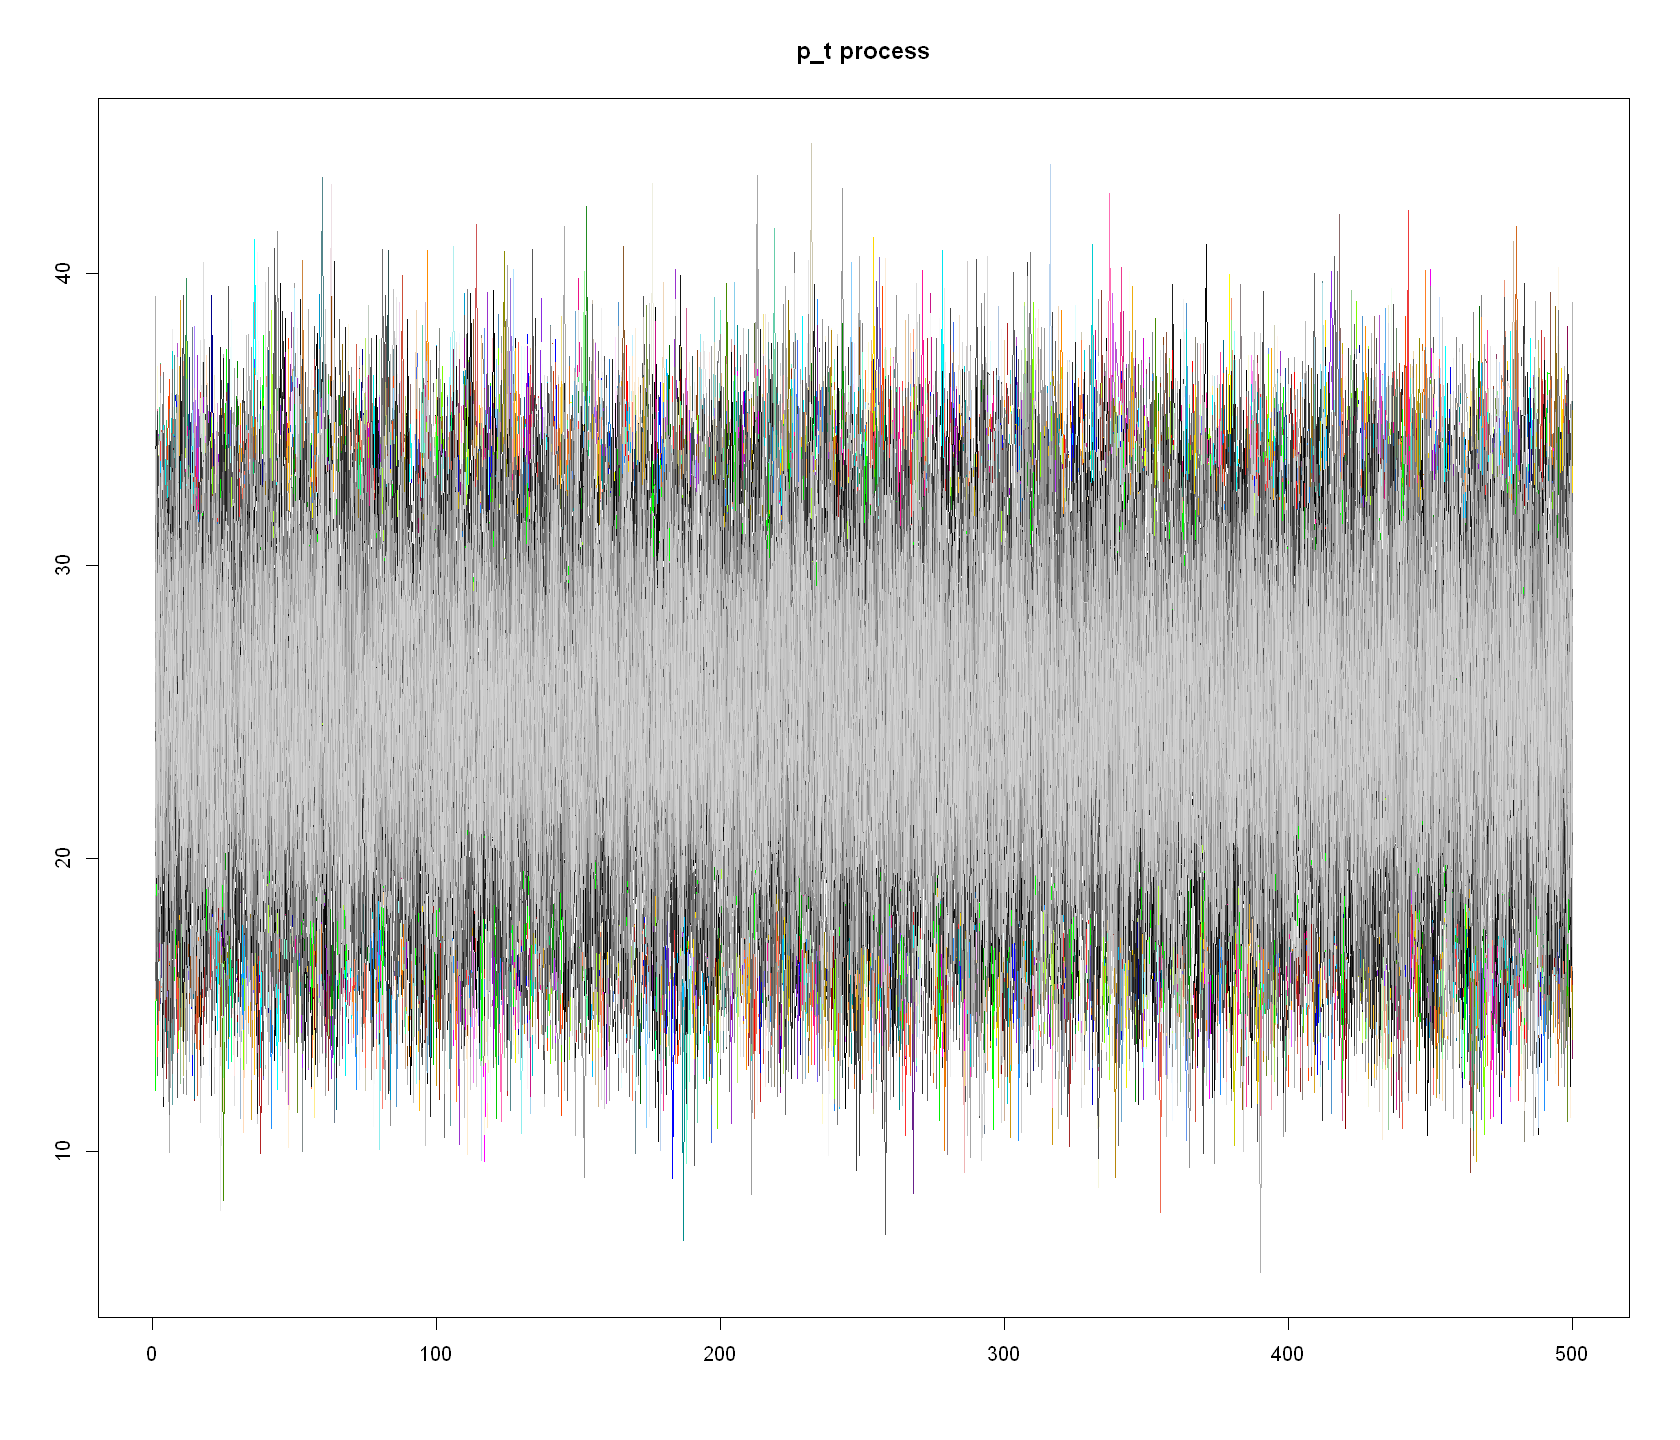

In [14]:
#p_t process
plot(pt_process[, 1], type = "l", xlab = "", ylab = "", main = "p_t process", ylim = c(min(pt_process), max(pt_process))) #Plotting the first realization to generate the plot
colors_999 <- c(setdiff(colors(), "black"), colors()[1:(1000 - length(colors()))]) #Creating a vector of 1000 colors. Since there are less than 1000 available, some will repeat
for (realiz in 2:1000) { #Adding a line for each realization
    lines(pt_process[, realiz], col = colors_999[realiz])
}

As can be seen from the plot above, the mean and the variance of the $p_t$ process indeed do not appear to change over time.

### $r_t$ process

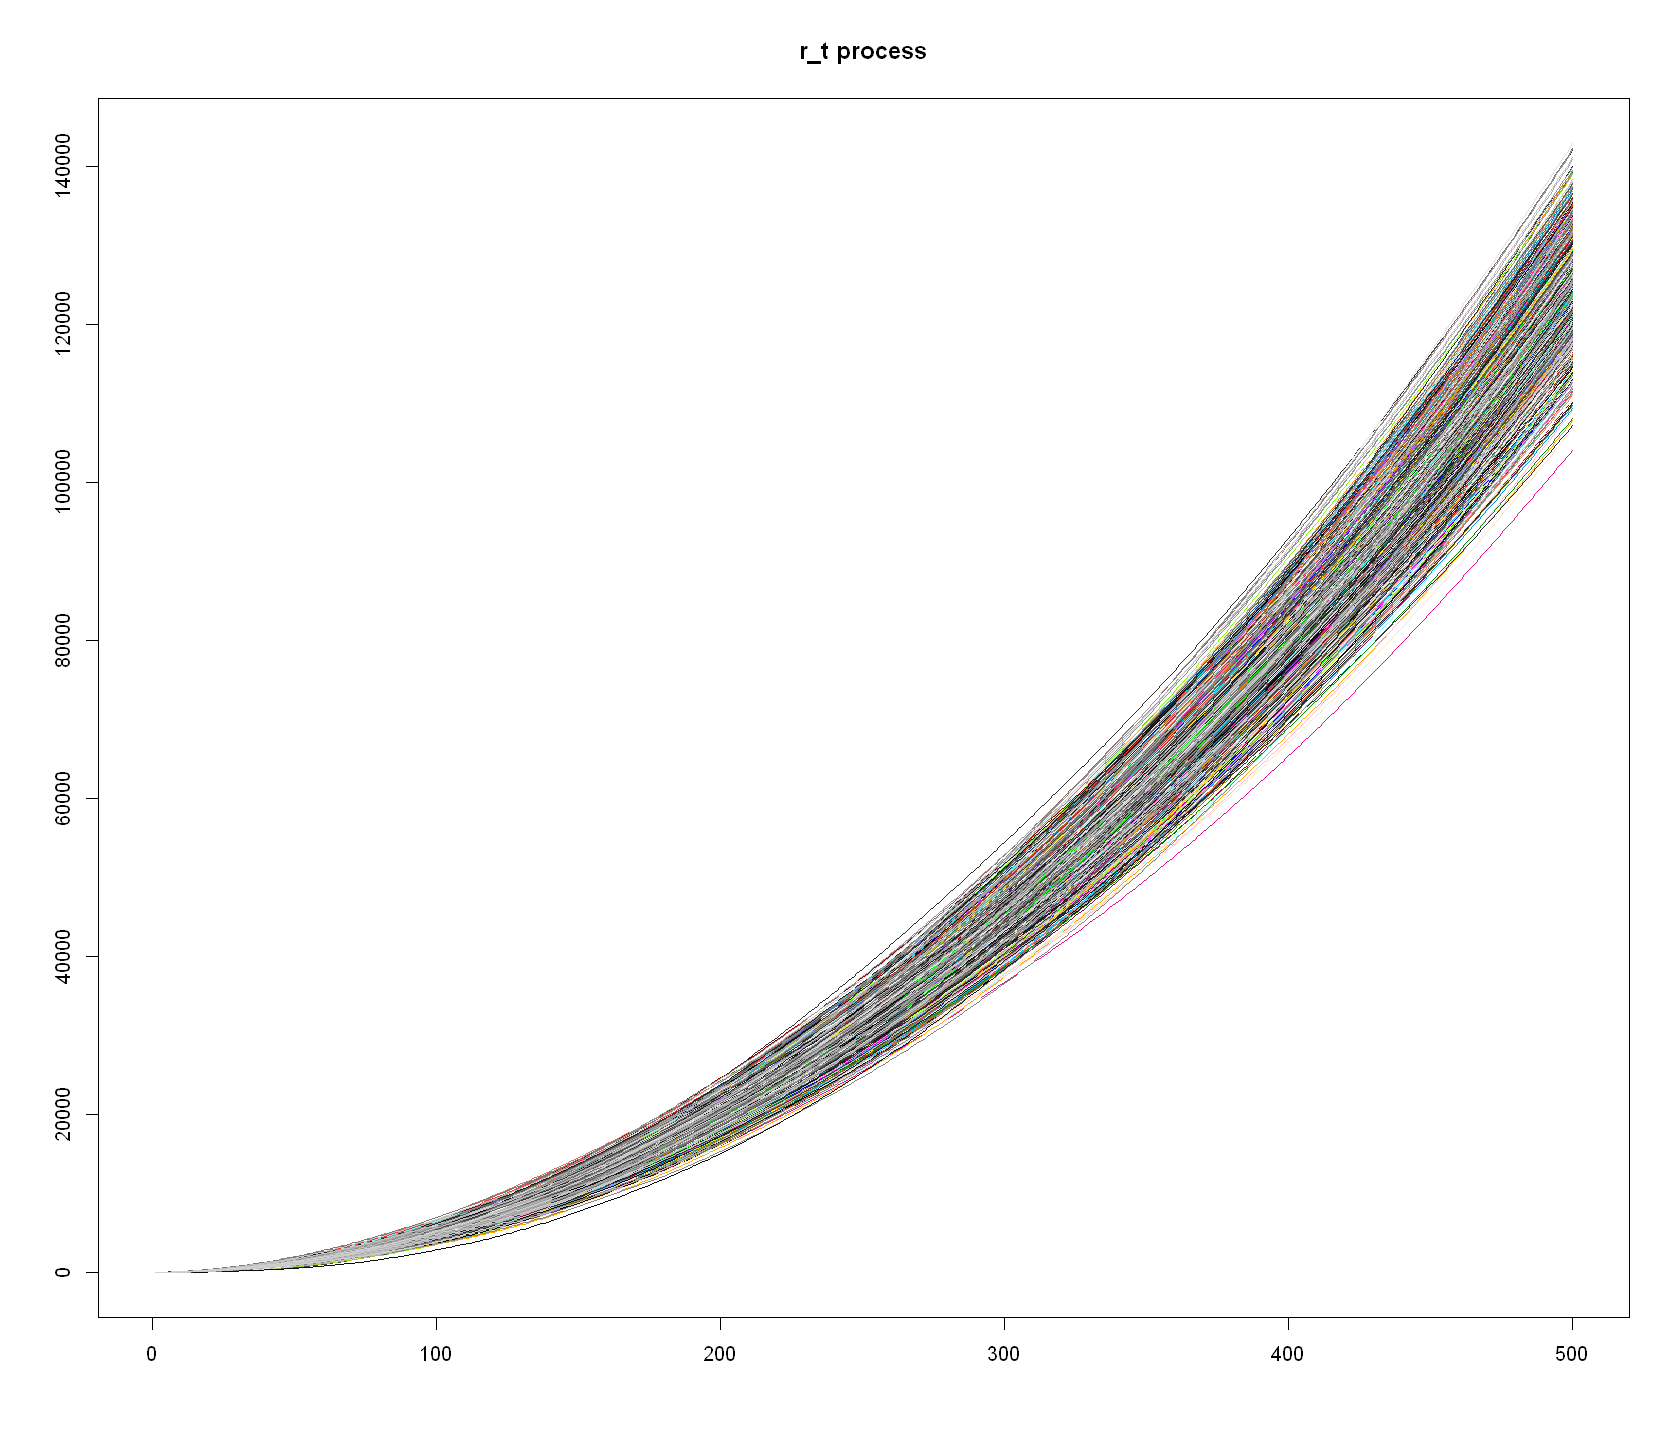

In [16]:
#r_t process
plot(rt_process[, 1], type = "l", xlab = "", ylab = "", main = "r_t process", ylim = c(min(rt_process), max(rt_process)))
for (realiz in 2:1000) { #Adding a line for each realization
    lines(rt_process[, realiz], col = colors_999[realiz])
}

As we have found above, the mean and variance of the $r_t$ process are both time dependent. From the graph we can see that the series explodes as the time goes. Both the mean and the variance increase with time.

In the last step we will compute $p_{200}$ and $r_{400}$. We do so by simply plugging into the previously derived formulas:
$$
p_{200}=p_0-\epsilon_0+\epsilon_{200}=25-0+\epsilon_{200}=25-\epsilon_{200}
$$
$$
r_{400}=r_0+\mu\frac{400(400+1)}{2}+400\epsilon_0+\sum_{i=1}^t (400+1-i)\eta_i=25+80200+\sum_{i=1}^t (401-i)\eta_i=80225+\sum_{i=1}^t (401-i)\eta_i
$$
where $\epsilon_{200}$ is a number from $N(0,4)$ and $\eta_1, \eta_2,..., \eta_{400}$ are numbers from $N(0,1)$